# Xarray使用技巧--绘图
将介绍`xarray`结合`matplotlib`和`cartopy`的绘图使用技巧
使用的数据来源和相关库的版本如下：
- **python：** 3.8.8
- **xarray：** 0.20.1
- **matplotlib：** 3.5.0
- **cartopy：** 0.19.0
- **numpy：** 1.19.5
- **GPCP降水数据：** 2.5 degree latitude x 2.5 degree longitude global 2.3 版本（version 2.3）[链接🔗](https://psl.noaa.gov/data/gridded/data.gpcp.html)


In [32]:
### 导入相关库
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import warnings
warnings.filterwarnings("ignore")
### 数据路径
file = 'precip.mon.mean.nc'
### 读取precip变量,时间从1979-01到2020-12
pre = xr.open_dataset(file).precip.sel(time = slice("1979-01","2020-12"))
print(pre.coords)

Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01


## 利用xarray内置的plot接口绘图
如果放入的数组是二维的，则绘制的是填色图：如绘制降水的年平均气候态：`pre.mean(dim = 'time').plot()`，可以设置如`figsize,ax`等参数（当然也可以使用`DataArray.plot.contourf()`绘制）
<br>如果放入的数组是一维的，则绘制的是折线图：`pre.mean(dim = ['lon','lat']).plot()`,可以设置如`color,linestyle`等参数

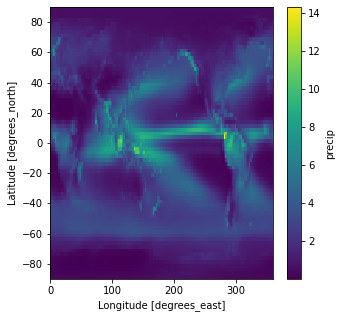

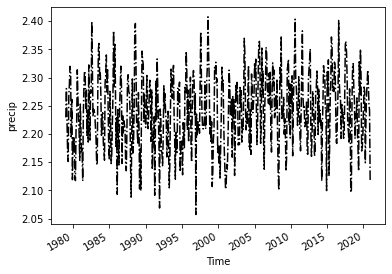

In [21]:
pre.mean(dim = 'time').plot(figsize = (5,5))
plt.show()
pre.mean(dim = ['lon','lat']).plot(color = 'k',linestyle = 'dashdot')
plt.show()

## 利用xarray内置的plot.contourf()绘制带地图底图和投影的填色图
需要利用`cartopy`定义投影类型，常用的有：`PlateCarree,LambertConformal,Robinson`等，`cartopy`提供了多种多样的投影类型，具体可以查看官网（[🔗](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html)）。

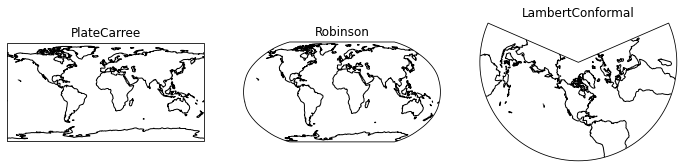

In [102]:
### 常用的投影类型
fig = plt.figure(figsize=(12,6))
proj_name = ['PlateCarree','Robinson','LambertConformal']
for i,proj in enumerate([ccrs.PlateCarree(),ccrs.Robinson(),ccrs.LambertConformal()]):
    ax = fig.add_subplot(1,3,1+i,projection=proj)
    ax.set_title(proj_name[i])
    ax.coastlines(resolution='110m')

在绘图之前，需要定义绘图的区域的相关特征，例如（设置什么样的投影，是否画海岸线等），这里给出一个绘图等例子（`ax`的设置）。使用时，需要将`ax`作为参数传入`plot.contourf()`中。

In [80]:
def ax_contourf():
    ## 定义画布
    fig = plt.figure(figsize=(8,4))
    ## 定义绘图区域和投影类型
    proj = ccrs.Robinson()## 设置投影的中心经度为180度
    ax = fig.add_subplot(1,1,1,projection=proj)
    ## 返回绘图区域ax
    return ax    

<font color = 'red'>需要注意的是，不管你选择的投影类型如何，都需要在`plot.contourf()`中加入`transform = ccrs.PlateCarree()`这一参数</font>。（cartopy官网关于transform的解释：The transform argument to plotting functions tells Cartopy what coordinate system your data are defined in. **IF**  We didn’t tell Cartopy what coordinate system our data are defined in, so it assumed it was the same as the projection we are plotting on, and the data are plotted in the wrong place.）

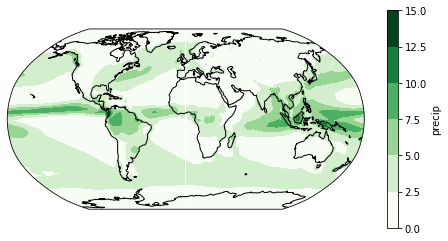

In [81]:
p = pre.mean(dim = 'time').plot.contourf(ax = ax_contourf(),cmap = plt.cm.Greens,transform = ccrs.PlateCarree())
p.axes.coastlines()## 添加海岸线

可以看到，如果只是这样绘图的话显得有些简单，没有我们想要的经纬度信息。现在就在`ax_contourf()`的基础上加入这些我们需要的元素。当然如果使用`Robinson`等非正形投影（non-rectangular projections）则不能使用下述方法增加经纬度信息。同时我们也可以设置关于colormap的色阶和要显示的区间，也可以设置colorbar放置的位置与大小（`orientation`设置colorbar是水平放置还是垂直放置，`shrink`设置colorbar的大小，`pad`设置colorbar和绘图区域的距离）。更多的设置详见[xarray官网](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.contourf.html)

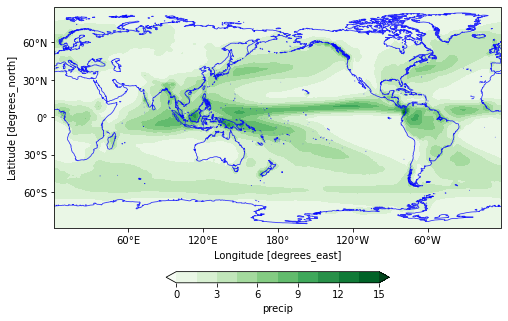

In [98]:
def ax_contourf():
    ## 定义画布
    fig = plt.figure(figsize=(8,8))
    ## 定义绘图区域和投影类型
    # proj = ## 设置投影的中心经度为180度
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
    ## 绘制经纬度坐标
    ax.set_xticks(np.arange(-180,180+60,60))
    ax.set_yticks(np.arange(-90,90+30,30))
    ax.xaxis.set_major_formatter(LongitudeFormatter())#刻度格式转换为经纬度样式 
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ## 返回绘图区域ax
    return ax  
### 绘制15个间隔levels = 15，设置cmap的颜色为Greens，设置颜色两端有延展extend = "both"，colobar的相关设置cbar_kwargs
p = pre.mean(dim = 'time').plot.contourf(ax = ax_contourf(),cmap = plt.cm.Greens,levels = 15,extend = "both",transform = ccrs.PlateCarree(),
                                         cbar_kwargs = {'orientation':'horizontal','shrink':0.5,'pad':0.1})
### 可以设置海岸线的分辨率，颜色，粗细，透明度等......
p.axes.coastlines(resolution='50m',color = 'b',linewidth = 0.8,alpha = 0.8)## 添加海岸线
plt.show()

## 关于非正形投影添加经纬度信息
可以简单地通过使用`ax.gridlines(draw_labels=True)`来添加经纬度信息，具体如下：

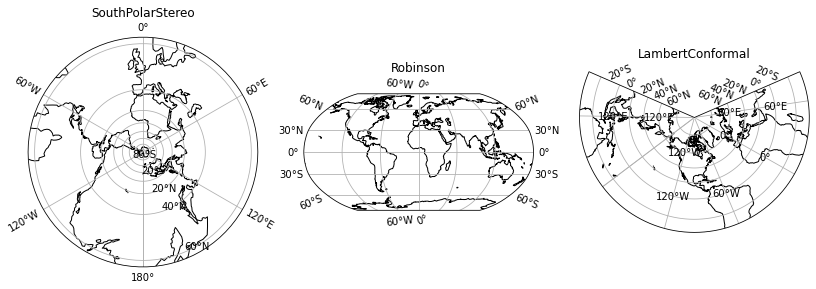

In [104]:
fig = plt.figure(figsize=(14,6))
proj_name = ['SouthPolarStereo','Robinson','LambertConformal']
for i,proj in enumerate([ccrs.SouthPolarStereo(),ccrs.Robinson(),ccrs.LambertConformal()]):
    ax = fig.add_subplot(1,3,1+i,projection=proj)
    ax.set_title(proj_name[i])
    ax.coastlines(resolution='110m')
    ax.gridlines(draw_labels=True)